# 9. CART
决策树的构建算法是ID3**（著名的ID3决策树学习算法[Quinlan, 1986]就是以信息增益为准则来选择划分属性）**。ID3的做法是每次选取当前最佳的特征来分割数据，并按照该特征的所有可能取值来切分。另一种切分方式是二元切分，即每次把数据切成两份，如果数据的某特征值等于切分所要求的值，那么这些数据就进入树的左子树，反之则进入树的右子树。  
CART使用二元切分来处理连续变量。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
# 根据阈值将数据集分为两部分
def binSplitDataSet(dataSet, feature, value):
    mat0 = dataSet[np.nonzero(dataSet[:,feature] > value)[0],:]
    mat1 = dataSet[np.nonzero(dataSet[:,feature] <= value)[0],:]
    return mat0, mat1

createTree伪代码：
```
找到最佳的待切分特征：
    如果该节点不能再分，将该节点存为叶节点
    执行二元切分
    在右子树调用createTree()方法
    在左子树调用createTree()方法
```

In [44]:
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)
    if feat == None:
        return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

In [45]:
testMat = np.mat(np.eye(4))
mat0,mat1 = binSplitDataSet(testMat,1,0.5)

In [46]:
mat0

matrix([[0., 1., 0., 0.]])

In [47]:
mat1

matrix([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [48]:
# 回归树的切分函数
def regLeaf(dataSet):
    return np.mean(dataSet[:,-1])

# 方差var和协方差cov
def regErr(dataSet):
    return np.var(dataSet[:,-1]*dataSet.shape[0])

def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    # 容许的误差下降值
    tolS = ops[0]
    # 切分的最少样本数
    tolN = ops[1]
    if len(set(dataSet[:,-1].T.tolist()[0]))==1:
        return None, leafType(dataSet)
    
    m,n = dataSet.shape
    S = errType(dataSet)
    bestS = np.inf
    bestIndex = 0
    bestValue = 0
    for featIndex in range(n-1):
        for splitVal in set(dataSet[:,featIndex].T.tolist()[0]):
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            if mat0.shape[0] < tolN or mat1.shape[0] < tolN:
                continue
            newS = errType(mat0) + errType(mat1)
            if newS < bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    if S - bestS < tolS:
        return None, leafType(dataSet)
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    if mat0.shape[0] < tolN or mat1.shape[0] < tolN:
        return None, leafType(dataSet)
    
    return bestIndex, bestValue

In [58]:
datadf = pd.read_csv("ex00.txt", sep='\t', header=None)
dataMat = np.mat(datadf)
createTree(dataMat)

{'left': {'left': {'left': {'left': {'left': 0.9558272857142859,
     'right': {'left': 0.91617825,
      'right': 1.00160025,
      'spInd': 0,
      'spVal': 0.936783},
     'spInd': 0,
     'spVal': 0.9531120000000001},
    'right': {'left': {'left': 1.0694294000000002,
      'right': 0.890274,
      'spInd': 0,
      'spVal': 0.860049},
     'right': 1.11825325,
     'spInd': 0,
     'spVal': 0.837522},
    'spInd': 0,
    'spVal': 0.8970940000000001},
   'right': {'left': {'left': 0.7364366,
     'right': {'left': 1.0177078,
      'right': 1.02496475,
      'spInd': 0,
      'spVal': 0.7731680000000001},
     'spInd': 0,
     'spVal': 0.7855409999999999},
    'right': {'left': {'left': 0.94992825,
      'right': 1.0915328,
      'spInd': 0,
      'spVal': 0.737189},
     'right': 0.9028684285714286,
     'spInd': 0,
     'spVal': 0.712503},
    'spInd': 0,
    'spVal': 0.761474},
   'spInd': 0,
   'spVal': 0.813719},
  'right': {'left': {'left': {'left': 1.1219195000000002,
     '

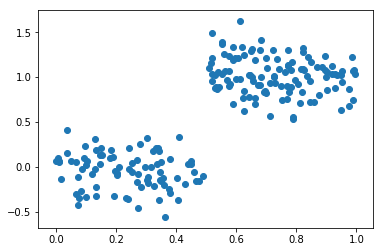

In [59]:
plt.scatter(datadf.iloc[:,0], datadf.iloc[:,1])
plt.show()

In [62]:
datadf1 = pd.read_csv("ex0.txt", sep='\t', header=None)
dataMat1 = np.mat(datadf1.iloc[:,1:3])
createTree(dataMat1)

{'left': {'left': {'left': {'left': {'left': 3.950397285714285,
     'right': 3.8569762499999998,
     'spInd': 0,
     'spVal': 0.983153},
    'right': {'left': 4.095781125,
     'right': 3.9507963333333342,
     'spInd': 0,
     'spVal': 0.9111879999999999},
    'spInd': 0,
    'spVal': 0.952758},
   'right': {'left': 3.9532527142857146,
    'right': {'left': 4.0267479999999995,
     'right': 4.0387635,
     'spInd': 0,
     'spVal': 0.832693},
    'spInd': 0,
    'spVal': 0.8454719999999999},
   'spInd': 0,
   'spVal': 0.881025},
  'right': {'left': {'left': {'left': {'left': 2.941999571428571,
      'right': 2.976717,
      'spInd': 0,
      'spVal': 0.771663},
     'right': {'left': 2.8879719999999995,
      'right': 3.0789625,
      'spInd': 0,
      'spVal': 0.71158},
     'spInd': 0,
     'spVal': 0.725426},
    'right': {'left': {'left': 2.9057242,
      'right': 3.035501857142857,
      'spInd': 0,
      'spVal': 0.670361},
     'right': 3.008841142857143,
     'spInd': 0,
  

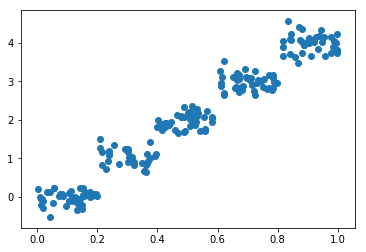

In [66]:
plt.scatter(datadf1.iloc[:,1], datadf1.iloc[:,2])
plt.show()

In [67]:
dataMat.shape

(200, 2)